# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

## Librería usada: OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la documentación oficial de OpenAI.

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee tres métodos principales (info. basada en la documentación oficial de Gym):


    reset(self): Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.
    step(self, action): "Avanza" un timestep del ambiente. Devuelve: observation, reward, done, info.
    render(self): Muestra en pantalla una parte del ambiente.
    close(self): Finaliza con la instancia del agente.
    seed(self): Establece la semilla aleatoria del generador de números aleatorios del presente entorno.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

    action_space: El objeto de tipo Space correspondiente al espacio de acciones válidas.
    observation_space: El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.
    reward_range: Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg. Para hacerlo desde Linux ejecutar en consola

	sudo apt-get install ffmpeg

desde Windows descargarla desde

[https://ffmpeg.zeranoe.com/builds/]()

Ejemplo: agente CartPole

In [1]:
import gym
import time
from IPython.display import clear_output

env = gym.make('CartPole-v0')
env.reset()
for _ in range(500):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

Ejemplo: agente Mountain Car

In [2]:
env = gym.make('MountainCar-v0')
observation = env.reset()
for t in range(500):
    env.render(mode='human')
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
clear_output()

## Ejemplo 1: The Cliff. 


![](images/cliffwalking.png)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* ^ - Arriba
* v - Abajo
* \> - Derecha
* < - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Primero, importamos:

In [3]:
import matplotlib.pyplot as plt
import itertools
import gym
import numpy as np
from agents.utils.plotting import plot_reward_per_episode, plot_steps_per_episode, plot_steps_per_episode_smooth, draw_value_matrix

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [4]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # a random action is selected

    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [5]:
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    
    
    # TODO - your code goes here
    
    q_current = q.get((state, action), 0.0)
    q_next = q.get((next_state, next_action), 0.0)
    q[state,action] = q_current + alpha*(reward+gamma*q_next - q_current)
    
    pass

Finalmente, definimos el método principal de iteraciones. 

In [6]:
def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(state)
            

            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [7]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 2000

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [8]:
actions

range(0, 4)

Ya instanciado, ejecutamos nuestro agente

In [9]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

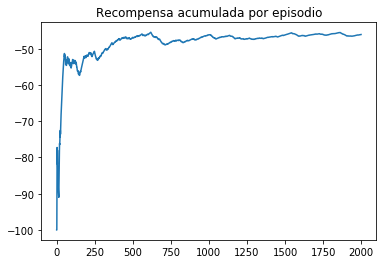

In [10]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

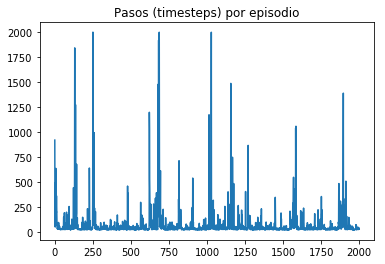

In [11]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

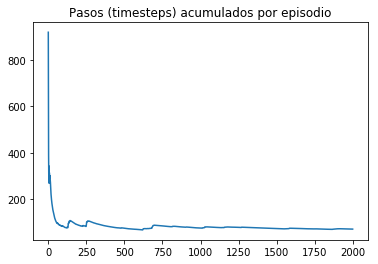

In [12]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

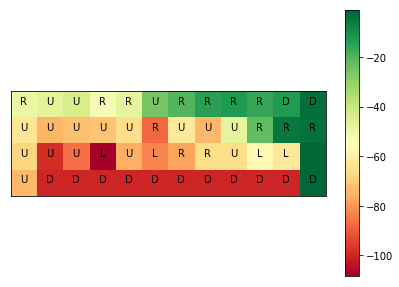


 Matriz de mejor acción-valor (en números): 

 [[ -49.46433605  -47.31934159  -43.63112977  -52.52346134  -47.77392323
   -25.58893601  -20.1506602   -14.13835926  -12.70780866  -15.85180959
   -13.144445     -3.00068117]
 [ -63.24133232  -74.35250252  -72.17104503  -71.28403904  -65.48401323
   -87.65010987  -62.37010746  -74.01043125  -47.91840162  -22.3601773
    -4.9874024    -3.10848682]
 [ -67.51221468  -98.1465802   -86.32528493 -108.42593117  -75.29533015
   -83.20325805  -77.52123532  -65.87805561  -65.89447884  -56.88195701
   -62.66639019   -1.        ]
 [ -74.00660277 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [13]:
draw_value_matrix(q)

In [14]:
env.close()

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, dada por $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{a'}e^{Q(s,a')/\tau}}$$



Para dejar el lab listo para su corrección, dejar link a repo de github con un notebook ejecutando el agente en la planilla enviada en Slack.

##### 1. SARSA

In [15]:
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    
    
    # TODO - your code goes here
    
    q_current = q.get((state, action), 0.0)
    q_next = q.get((next_state, next_action), 0.0)
    q[state,action] = q_current + alpha*(reward+gamma*q_next - q_current)
    
    pass

In [16]:
def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(state)
            

            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [17]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

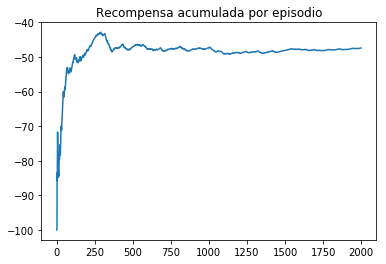

In [18]:
plot_reward_per_episode(reward_ep)

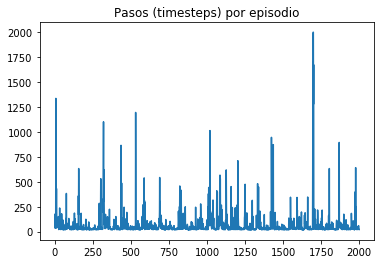

In [19]:
plot_steps_per_episode(timesteps_ep)

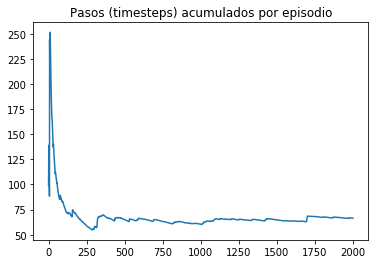

In [20]:
plot_steps_per_episode_smooth(timesteps_ep)

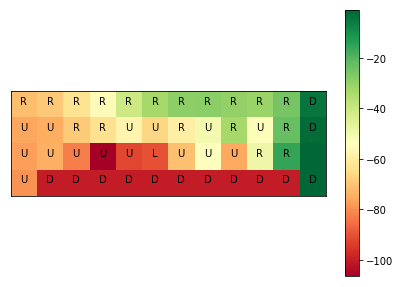


 Matriz de mejor acción-valor (en números): 

 [[ -71.23403066  -69.01461667  -62.86035803  -55.37860019  -40.94240392
   -33.01572599  -28.63988081  -28.57712411  -29.6284354   -30.94114473
   -25.09204059   -4.14883651]
 [ -75.90311628  -74.6757468   -68.88523901  -63.56780126  -57.16560722
   -65.7010618   -58.71218494  -50.73669307  -32.79745617  -52.91048811
   -22.54146588   -2.13410484]
 [ -77.14347969  -74.10695319  -82.57132295 -106.47085362  -91.86605729
   -90.2402799   -70.94604086  -54.13969784  -75.19203586  -48.97340476
   -15.31953937   -1.        ]
 [ -79.25791965 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [21]:
draw_value_matrix(q)

##### 2. Q-Learning

In [22]:
def Q_learning(state, action, reward, next_state):
    """
    Performs a Q-learning 
    """
    
    
    # TODO - your code goes here
    
    q_current = q.get((state, action), 0.0)
    q_next_state_Actions =[q.get((next_state, a), 0.0) for a in actions] #Nos devuelve los valores de cada accion (4) del siguiente estado
    #q_next_state_Actions =[v for k,v in q.items() if k[0]==next_state]
    q_next_max = max(q_next_state_Actions) #Obtenemos el valor (Q) máximo de las acciones del siguiente estado

    q[state,action] = q_current + alpha*(reward+gamma*q_next_max - q_current)
  
    pass

In [23]:
def run_off():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(2000):#episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(state)
            

            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                Q_learning(state, action, reward, next_state)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [24]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_off()

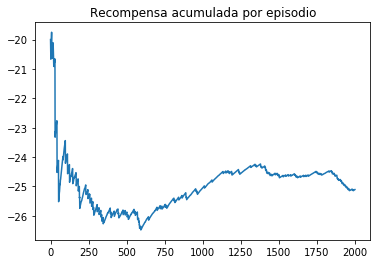

In [25]:
plot_reward_per_episode(reward_ep)

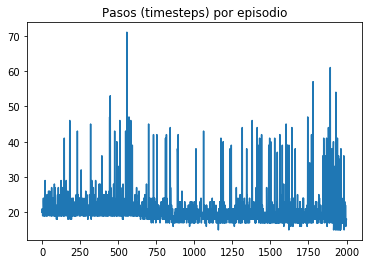

In [26]:
plot_steps_per_episode(timesteps_ep)

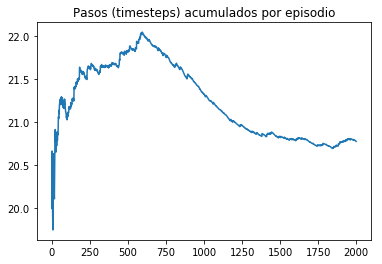

In [27]:
plot_steps_per_episode_smooth(timesteps_ep)

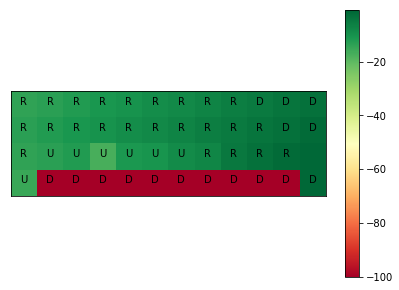


 Matriz de mejor acción-valor (en números): 

 [[ -14.          -13.          -12.          -11.          -10.
    -9.           -8.           -7.           -6.           -5.
    -4.           -3.        ]
 [ -13.          -12.          -11.          -10.           -9.
    -8.           -7.           -6.           -5.           -4.
    -3.           -2.        ]
 [ -14.          -13.          -12.00443212  -16.96693005  -11.27919738
   -10.43936495   -8.49412868   -7.39907621   -4.50873877   -3.00280609
    -2.           -1.        ]
 [ -15.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [28]:
draw_value_matrix(q)

La convergencia de **Q-Learning** respecto a **SARSA** es que en la teoría, el segundo de estos implementa un mecanismo *On-Policy*, el cual "explota" la acción asociada a la politica establecida, lo que lleva a este algoritmo a utilizar acciónes "conservadoras" las cuales aseguren una convergencia sin necesidad de que esta sea óptima, sino más "segura", evitando recompensas negativas.

Por el contrario **Q-Learning** se basa en una implementación *Off-Policy*, cuyo valor es independiente de la política utilizada (e.g utilizando *e-greedy*), esto nos lleva a ponderar  (en el trade-off) la *exploración* por sobre la *explotación*, el cual conduce al agente a seleccionar la acción óptima con la consecuencia de obtener mayores recompensas-negativas, pero logrando al final del entrenamiento obtener un camino óptimo en relación a **SARSA**.

###### *Estas apreciaciones son respaldadas tanto por la matriz de valores -en la que SARSA se aleja de la zona de recompensas-negativas con poca exploración, mientras que Q-Learning explora hasta tal punto de obtener el camino más arriesgado pero óptimo-, como también por el gráfico de recompensas por episodios, en la que SARSA obtiene un número de recompensas acumuladas notablemente superior a Q-Learning, ya que siguió un camino mucho menos arriesgado que este último.*


### 3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

**Gamma** $\gamma$ es el *factor de descuento* y se encarga de ponderar las recompensas, en cuyo caso si su valor es *cero*, anula el "conocimiento/influencia" de las recompensas futuras, mientras que si su valor es de *uno*, brindará la misma importancia a todas las recompensas.

**Alpha** $\alpha$ se lo denomina como *"learning-rate"* o *"taza de aprendizaje"*, cumple la función de determinar "cuanta" nueva información se considerará por sobre la información ya adquirida previamente.
En tal caso si el valor de éste es *cero* entonces se mantendrá la información actual sin *"sobreescribir"* ni *"aprender"* nada, mientras que si el valor es de *uno*, se *"sobreescribirá"* toda la información previa con la nueva.

**Epsilon** $\epsilon$ está a asociado al *trade-off* exploración-explotación de la política a implementar (e.j. e-greedy, e-decreasing, e-first, etc.). 

En la cual por ejemplo en *e-greedy* utilizamos una relación de probabilidad 1-e, en la cual (caso extremo) si e=1 la acción a elegir será aleatoria (pura exploración), mientras que si e=0 entonces las acciones ya estaran determinadas (pura explotación).

En el caso de *e-first* esta relación será intercalada, una fase de pura exploración (con probabilidad uniforme entre las acciones) es seguida de una fase de pura explotación (selección de la mejor acción)

En el caso de *e-decreasing*, como su nombre lo indica, se comienza con un valor alto de epsilon, el cual va a ir disminuyendo a medida que transcurra el entrenamiento, lo que provocará que las primeras selecciones de acciones sean mayoritariamente de exploración, mientras que las ultimas serán principalmente de explotación. 


In [29]:
## Hipermarametros
gamma= 1 #0
alpha= 0 #1
epsilon = 0 #0

In [30]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

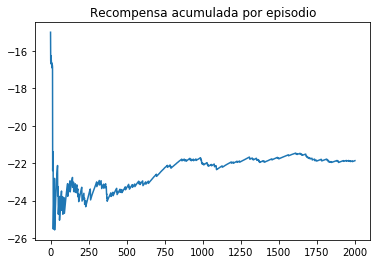

In [31]:
plot_reward_per_episode(reward_ep)

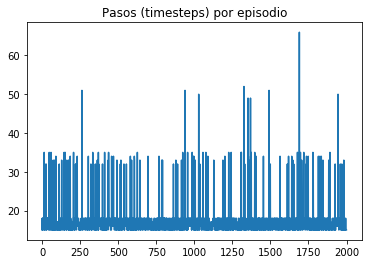

In [32]:
plot_steps_per_episode(timesteps_ep)

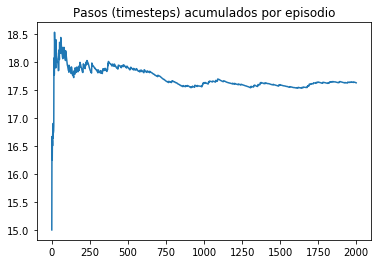

In [33]:
plot_steps_per_episode_smooth(timesteps_ep)

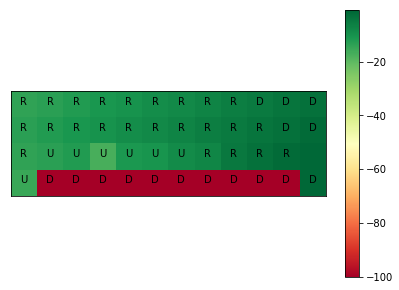


 Matriz de mejor acción-valor (en números): 

 [[ -14.          -13.          -12.          -11.          -10.
    -9.           -8.           -7.           -6.           -5.
    -4.           -3.        ]
 [ -13.          -12.          -11.          -10.           -9.
    -8.           -7.           -6.           -5.           -4.
    -3.           -2.        ]
 [ -14.          -13.          -12.00443212  -16.96693005  -11.27919738
   -10.43936495   -8.49412868   -7.39907621   -4.50873877   -3.00280609
    -2.           -1.        ]
 [ -15.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [34]:
draw_value_matrix(q)


#### 4. (Opcional) Implementar política de exploración Softmax, dada por $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{a'}e^{Q(s,a')/\tau}}$$


Implementaremos una nueva política a través de Softmax, convirtiendo los valores asociados de cada acción a su correspondiente probabilístico, luego seleccionaremos "aleatoriamente" una de esas acciones.

Recordemos que el valor de **tau** (parámetro de temperatura) nos da un threshold sobre la diferencia entre las probabilidades de las acciones, en la que, cuando **tau** *tiende a infinito* entonces las acciones serán equiprobables, mientras que si **tau** *tiende a cero+ (por derecha)* la probabilidad de la acción mayoritaria sera de valor 1 (100%), lo que nos daría una política con *argmax* como en el caso de los ejercicios anteriores.

In [35]:
alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25
no_zero = 0.0000001

In [36]:
#Creamos la funcion softmax
def softmax_rl(Q,Qn,t):
        
    #Función softmax
    politiks = np.array(np.matrix(np.exp(np.array(np.matrix(Q)/t)[0]))/(np.sum(np.array(np.matrix(Qn)/t)[0])+no_zero))[0]#Kilombito para dividir una lista por un escalar (lo pasamos a matriz para operar con escalares y volvemos a lista)
    
    
    #print("array",politiks)
    politik = np.random.choice(politiks) #Selección probabilística de la acción
    #print("elemento",politik)
    
    
    #Indice de la acción
    politik_i = np.where(np.isclose(politiks, politik)) 
    
    
    politik_i = politik_i[0]
    #print("indice_s",politik_i, "cantidad indices",len(politik_i))
    
    #con este condicional evitamos problemas de tener 2 acciones equiprobables
    if len(politik_i) > 1:
        
        politik_i = politik_i[0]
        #print("es mayor? a 1-----> enconces es:",politik_i)
    else:
        
        #print("es igual a 1-----> enconces es:",politik_i)
        politik_i = politik_i[0]
    
    
    return politik, politik_i

In [37]:
#Implementamos softmax
def choose_action(state, next_state):
    
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
   
    q_next_state_Actions =[q.get((next_state, a), 0.0) for a in actions] #Nos devuelve los valores de cada accion (4) del siguiente estado

    #en vez de optener la acción con máximo valor_q, obtenemos la accion por softmax, con el índice correspondiente
    max_q, max_q_i = softmax_rl(q_values, q_next_state_Actions,tau)  
    
    #print (max_q_i)
    if random_state.uniform() < epsilon:
     
        return random_state.choice(actions)  # a random action is selected
  
    return actions[max_q_i]

In [38]:
def Q_learning(state, action, reward, next_state):
    """
    Performs a Q-learning 
    """
    
    
    # TODO - your code goes here
    
    q_current = q.get((state, action), 0.0)
    q_next_state_Actions =[q.get((next_state, a), 0.0) for a in actions] #Nos devuelve los valores de cada accion (4) del siguiente estado
    #q_next_state_Actions =[v for k,v in q.items() if k[0]==next_state]
    #q_next_max = max(q_next_state_Actions) #Obtenemos el valor (Q) máximo de las acciones del siguiente estado

    
    q_next_soft, _ = softmax_rl(q_current, q_next_state_Actions,tau) #Obtenemos el valor (Q) del softmax de las acciónes
    
    q[state,action] = q_current + alpha*(reward+gamma*q_next_soft - q_current)
  
    pass

In [39]:
def run_soft():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(2000):#episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        next_state = state #Creamos un next_state para usar el softmax desde el inicio
        
        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state, next_state)# Agregamos para el softmax
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(state, next_state)# Agregamos next_state para el softmax
            

            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                Q_learning(state, action, reward, next_state)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [40]:
avg_steps_per_episode, timesteps_ep, reward_ep = run_soft()

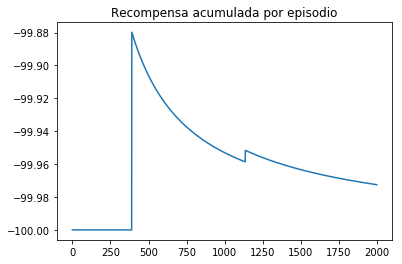

In [41]:
plot_reward_per_episode(reward_ep)

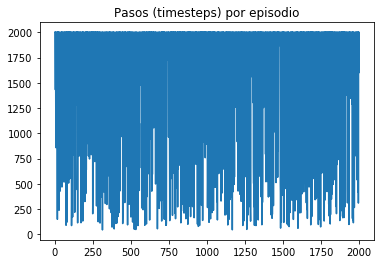

In [42]:
plot_steps_per_episode(timesteps_ep)

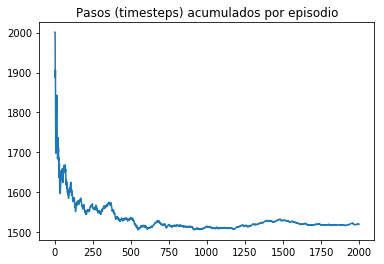

In [43]:
plot_steps_per_episode_smooth(timesteps_ep)

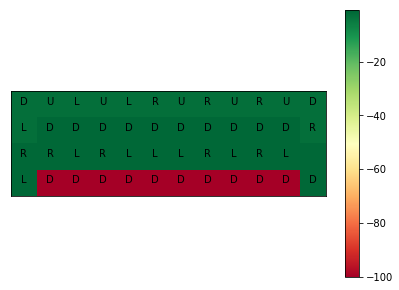


 Matriz de mejor acción-valor (en números): 

 [[  -2.80017303   -2.87383265   -2.87383417   -2.88773006   -2.8879792
    -2.88849596   -2.88849255   -2.88763426   -2.88762222   -2.8736262
    -2.87363783   -2.79475351]
 [  -2.80017316   -1.22062004   -1.22549522   -1.2254536    -1.22544555
    -1.2254547    -1.22545419   -1.2254558    -1.22544788   -1.22549584
    -1.22052145   -2.79449537]
 [  -1.22062003   -1.22549523   -1.22062016   -1.22544551   -1.22545308
    -1.22544684   -1.22545408   -1.22544789   -1.22545578   -1.22052093
    -1.22549582   -1.        ]
 [  -1.22469462 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [44]:
draw_value_matrix(q)

*(Resultados no concluyente)*